# Notebook for analysing results of the naming game, matrices visualizations

This notebook can be used for generating videos of all the naming matrices during training for a specific seed. A video of the evolution of the naming matrices will be stored in the experiment's directory

In [1]:
import os
import random
import tempfile
from copy import deepcopy
from datetime import datetime

import click
import imgc_marl.envs.population as population
import numpy as np
import yaml
from imgc_marl.callbacks import (
    PopGoalLinesCallback,
    PopGoalLinesCommunicationCallback,
    PopGoalLinesNamingCallback,
    PopGoalLinesNamingCallback1Matrix,
)
from imgc_marl.evaluation import (
    communication_custom_eval_function,
    custom_eval_function,
)
from imgc_marl.models.basic_communication import BasicCommunicationNetwork
from imgc_marl.models.full_naming_game import FullNamingNetwork
from imgc_marl.models.full_naming_game_single_matrix import FullNamingNetwork1Matrix
from imgc_marl.policies.basic_communication import BasicCommunicationTrainer
from imgc_marl.policies.full_naming_game import FullNamingTrainer
from imgc_marl.policies.full_naming_game_single_matrix import FullNamingTrainer1Matrix
from imgc_marl.utils import keep_relevant_results
from ray.rllib.agents.ppo import DEFAULT_CONFIG, PPOTrainer
from ray.rllib.models import ModelCatalog
from ray.rllib.policy.policy import PolicySpec
from ray.tune.logger import UnifiedLogger, pretty_print
import torch
import matplotlib.pyplot as plt
import moviepy

* Select correct configuration file 
* Select environment (3 or 6 landmarks)
* Select the experiment you want to evaluate

In [2]:
!ls $SCRATCH/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game/2_matrix


2022-10-15_20-21-051i6ubnd9  train-152633_0.slurm.err  train-152633_2.slurm.out
2022-10-15_20-21-055x1s5ecg  train-152633_0.slurm.out  train-152633_3.slurm.err
2022-10-15_20-21-05l2jrttu4  train-152633_1.slurm.err  train-152633_3.slurm.out
2022-10-15_20-21-05n2r125tc  train-152633_1.slurm.out  train-152633_4.slurm.err
2022-10-15_20-21-05zvlbcbhk  train-152633_2.slurm.err  train-152633_4.slurm.out


In [2]:
!ls $SCRATCH/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30


2022-10-27_19-14-40v1v3_6dl  stdout.txt		       train-493234_2.slurm.out
2022-10-27_19-19-56_8ve71_y  train-493234_0.slurm.err  train-493234_3.slurm.err
2022-10-27_19-21-22pozgzx7i  train-493234_0.slurm.out  train-493234_3.slurm.out
2022-10-27_19-24-53kh4dr43g  train-493234_1.slurm.err  train-493234_4.slurm.err
2022-10-27_19-24-53qlfxv7fz  train-493234_1.slurm.out  train-493234_4.slurm.out
stderr.txt		     train-493234_2.slurm.err


In [45]:
!ls $SCRATCH/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b


2022-10-25_22-07-33e3kaf119  train-427643_0.slurm.err  train-427643_2.slurm.out
2022-10-25_22-07-3606x7jyz3  train-427643_0.slurm.out  train-427643_3.slurm.err
2022-10-25_22-07-369e50deqs  train-427643_1.slurm.err  train-427643_3.slurm.out
2022-10-25_22-07-36nrhqi86q  train-427643_1.slurm.out  train-427643_4.slurm.err
2022-10-25_22-07-44fppth2yq  train-427643_2.slurm.err  train-427643_4.slurm.out


In [9]:
from imgc_marl.envs.population import PopGoalLinesEnv, PopLargeGoalLinesEnv

# 3 landmarks
#config_file = "goal_lines_naming.yml"
config_file="goal_lines_2agents_naming_game_all_modified.yml"
environment = PopGoalLinesEnv

# 6 landmarks
#config_file = "large_goal_lines_2agents_naming_game_all_modified.yml"
#environment = PopLargeGoalLinesEnv


# directory of the checkpoints you want to evaluate
checkpoints_dir = os.environ["SCRATCH"]+"/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl"

In [5]:
from imgc_marl.envs.population import PopGoalLinesEnv, PopLargeGoalLinesEnv

# 3 landmarks
#config_file = "goal_lines_naming.yml"
config_file="goal_lines_2agents_naming_game_all_modified.yml"
environment = PopGoalLinesEnv

# 6 landmarks
#config_file = "large_goal_lines_naming.yml"
#environment = PopLargeGoalLinesEnv


# directory of the checkpoints you want to evaluate
checkpoints_dir = os.environ["SCRATCH"]+"/elias_expe/2_agents/all/modified_reward/3_landmarks/naming_game_30msg_alpha05_temp30/2022-10-20_01-15-1472rqeu15"

In [10]:
with open(f"../scripts/configs/{config_file}", "r") as f:
    user_config = yaml.safe_load(f)
# General settings of the algorithm
config = deepcopy(DEFAULT_CONFIG)
config["num_workers"] = 0
config["framework"] = "torch"
use_communication = user_config.get("communication", False)

config["horizon"] = 300
config["rollout_fragment_length"] = config["horizon"]
config["env_config"] = user_config["env_config"]
config["train_batch_size"] = 60_000
config["sgd_minibatch_size"] = 10_000
config["lambda"] = 0.9
config["lr"] = 0.0003


nb_msg= 30

def policy_mapping_fn(agent_id):
    return agent_id


config["multiagent"] = {
    "policies": {
        f"agent_{i}": PolicySpec(
            policy_class=None, observation_space=None, action_space=None
        )
        for i in range(config["env_config"]["population_size"])
    },
    "policy_mapping_fn": policy_mapping_fn,
}

train_env = environment

ModelCatalog.register_custom_model("FullNamingNetwork1Matrix", FullNamingNetwork1Matrix)
number_of_goals = environment(config["env_config"]).goal_space_dim
config["model"] = {
    "custom_model": "FullNamingNetwork1Matrix",
    "custom_model_config": {
        "number_of_goals": number_of_goals,
        "train_matrix": user_config.get("train_matrix", False),
        "nb_msg":nb_msg,
    },
}
trainer = FullNamingTrainer1Matrix(
    config=config,
    env=train_env,
)

2022-10-28 10:33:40,515	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-10-28 10:33:40,516	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-10-28 10:33:40,516	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-10-28 10:33:40,517	WARNING multi_agent_env.py:193 -- action_space_sample() has not been implemented
2022-10-28 10:33:40,518	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-10-28 10:33:40,524	WARNING catalog.py:628 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2022-10-28 10:33:40,540	WARNING catalog.py:628 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


# Inspecting matrices through time

checkpoint-10


2022-10-28 10:34:00,803	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000010/checkpoint-10
2022-10-28 10:34:00,804	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': None, '_time_total': 454.62507367134094, '_episodes_total': 2793}
2022-10-28 10:34:01,083	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000020/checkpoint-20
2022-10-28 10:34:01,083	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': None, '_time_total': 913.6632552146912, '_episodes_total': 8613}


checkpoint-20


2022-10-28 10:34:01,352	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000030/checkpoint-30
2022-10-28 10:34:01,352	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 30, '_timesteps_total': None, '_time_total': 1369.158375263214, '_episodes_total': 19069}


checkpoint-30


2022-10-28 10:34:01,556	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000040/checkpoint-40
2022-10-28 10:34:01,560	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 40, '_timesteps_total': None, '_time_total': 1841.3229908943176, '_episodes_total': 32017}


checkpoint-40


2022-10-28 10:34:01,828	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000050/checkpoint-50
2022-10-28 10:34:01,829	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 50, '_timesteps_total': None, '_time_total': 2314.47483587265, '_episodes_total': 45309}


checkpoint-50


2022-10-28 10:34:02,266	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000060/checkpoint-60
2022-10-28 10:34:02,267	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 60, '_timesteps_total': None, '_time_total': 2807.906049489975, '_episodes_total': 58439}


checkpoint-60


2022-10-28 10:34:02,536	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000070/checkpoint-70
2022-10-28 10:34:02,537	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 70, '_timesteps_total': None, '_time_total': 3412.6584622859955, '_episodes_total': 71900}


checkpoint-70


2022-10-28 10:34:02,806	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000080/checkpoint-80
2022-10-28 10:34:02,806	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 80, '_timesteps_total': None, '_time_total': 3961.137195110321, '_episodes_total': 85498}


checkpoint-80


2022-10-28 10:34:03,070	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000090/checkpoint-90
2022-10-28 10:34:03,071	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 90, '_timesteps_total': None, '_time_total': 4471.144795656204, '_episodes_total': 98847}


checkpoint-90


2022-10-28 10:34:03,347	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000100/checkpoint-100
2022-10-28 10:34:03,347	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 5057.337912321091, '_episodes_total': 112016}


checkpoint-100


2022-10-28 10:34:03,606	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000110/checkpoint-110
2022-10-28 10:34:03,607	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 110, '_timesteps_total': None, '_time_total': 5589.631548166275, '_episodes_total': 125205}


checkpoint-110


2022-10-28 10:34:03,866	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000120/checkpoint-120
2022-10-28 10:34:03,868	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 120, '_timesteps_total': None, '_time_total': 6111.158798933029, '_episodes_total': 138482}


checkpoint-120


2022-10-28 10:34:04,137	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000130/checkpoint-130
2022-10-28 10:34:04,140	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 130, '_timesteps_total': None, '_time_total': 6651.238924026489, '_episodes_total': 152061}


checkpoint-130


2022-10-28 10:34:04,409	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000140/checkpoint-140
2022-10-28 10:34:04,410	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 140, '_timesteps_total': None, '_time_total': 7163.3968098163605, '_episodes_total': 165401}


checkpoint-140


2022-10-28 10:34:04,674	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000150/checkpoint-150
2022-10-28 10:34:04,674	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 150, '_timesteps_total': None, '_time_total': 7768.003048419952, '_episodes_total': 178635}


checkpoint-150


2022-10-28 10:34:04,880	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000160/checkpoint-160
2022-10-28 10:34:04,887	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 160, '_timesteps_total': None, '_time_total': 8329.253116369247, '_episodes_total': 191975}


checkpoint-160


2022-10-28 10:34:05,154	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000170/checkpoint-170
2022-10-28 10:34:05,154	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 170, '_timesteps_total': None, '_time_total': 8852.435687065125, '_episodes_total': 205202}


checkpoint-170


2022-10-28 10:34:05,426	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000180/checkpoint-180
2022-10-28 10:34:05,427	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 180, '_timesteps_total': None, '_time_total': 9403.699460983276, '_episodes_total': 218651}


checkpoint-180


2022-10-28 10:34:05,633	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000190/checkpoint-190
2022-10-28 10:34:05,634	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 190, '_timesteps_total': None, '_time_total': 9920.983267784119, '_episodes_total': 232088}


checkpoint-190


2022-10-28 10:34:05,901	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000200/checkpoint-200
2022-10-28 10:34:05,902	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 200, '_timesteps_total': None, '_time_total': 10446.013216733932, '_episodes_total': 245656}


checkpoint-200


2022-10-28 10:34:06,277	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000210/checkpoint-210
2022-10-28 10:34:06,278	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 210, '_timesteps_total': None, '_time_total': 11038.544260501862, '_episodes_total': 259032}


checkpoint-210
checkpoint-220


2022-10-28 10:34:06,540	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000220/checkpoint-220
2022-10-28 10:34:06,540	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 220, '_timesteps_total': None, '_time_total': 11561.213726043701, '_episodes_total': 272567}
2022-10-28 10:34:06,743	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000230/checkpoint-230
2022-10-28 10:34:06,744	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 230, '_timesteps_total': None, '_time_total': 12086.260548591614, '_episodes_total': 286271}


checkpoint-230


2022-10-28 10:34:07,007	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000240/checkpoint-240
2022-10-28 10:34:07,007	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 240, '_timesteps_total': None, '_time_total': 12609.811352014542, '_episodes_total': 299849}


checkpoint-240


2022-10-28 10:34:07,268	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000250/checkpoint-250
2022-10-28 10:34:07,270	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 250, '_timesteps_total': None, '_time_total': 13106.82937836647, '_episodes_total': 313616}


checkpoint-250


2022-10-28 10:34:07,520	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000260/checkpoint-260
2022-10-28 10:34:07,522	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 260, '_timesteps_total': None, '_time_total': 13656.268040180206, '_episodes_total': 327135}


checkpoint-260


2022-10-28 10:34:07,728	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000270/checkpoint-270
2022-10-28 10:34:07,728	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 270, '_timesteps_total': None, '_time_total': 14221.347922801971, '_episodes_total': 340775}


checkpoint-270


2022-10-28 10:34:07,997	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000280/checkpoint-280
2022-10-28 10:34:07,997	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 280, '_timesteps_total': None, '_time_total': 14763.553443193436, '_episodes_total': 354508}


checkpoint-280


2022-10-28 10:34:08,263	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000290/checkpoint-290
2022-10-28 10:34:08,264	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 290, '_timesteps_total': None, '_time_total': 15322.773516893387, '_episodes_total': 368522}


checkpoint-290


2022-10-28 10:34:08,521	INFO trainable.py:588 -- Restored on 10.159.0.6 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/3_landmarks_reward1/naming_game_30msg_alpha10_temp30/2022-10-27_19-14-40v1v3_6dl/checkpoint_000300/checkpoint-300
2022-10-28 10:34:08,523	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 300, '_timesteps_total': None, '_time_total': 15838.688460588455, '_episodes_total': 382169}


checkpoint-300


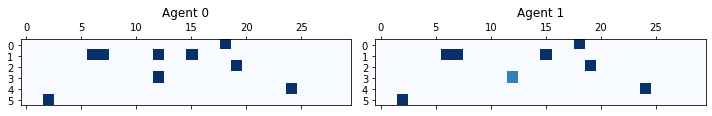

In [11]:
imgs = []
for checkpoint_dir in sorted(os.listdir(checkpoints_dir)):
    if os.path.isdir(os.path.join(checkpoints_dir, checkpoint_dir)):
        checkpoint_file = sorted(
            os.listdir(os.path.join(checkpoints_dir, checkpoint_dir))
        )[1]
        print(checkpoint_file)
        trainer.restore(os.path.join(checkpoints_dir, checkpoint_dir, checkpoint_file))
        agent_0 = trainer.get_policy("agent_0").model
        agent_1 = trainer.get_policy("agent_1").model
        with torch.no_grad():
            agent_0_matrix = agent_0._matrix.numpy()
            agent_1_matrix = agent_1._matrix.numpy()

            # Generate images
            for j, matrix in enumerate((agent_0_matrix, agent_1_matrix)):
                if j == 0:
                    fig = plt.figure(num=1, clear=True, figsize=(10, 10))
                    ax = fig.add_subplot(121)
                    ax.set_title("Agent 0")
                elif j == 1:
                    ax = fig.add_subplot(122)
                    ax.set_title("Agent 1")
                ax.matshow(matrix, cmap=plt.cm.Blues)
                for x in range(nb_msg):
                    for y in range(number_of_goals):
                        c = matrix[y, x]
                        #ax.text(x, y, str(round(c, 3)), va="center", ha="center")
                if j == 1:
                    plt.tight_layout()
                    canvas = fig.figure.canvas
                    canvas.draw()
                    data = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
                    img = data.reshape(canvas.get_width_height()[::-1] + (3,))
                    imgs.append(img)
                    

In [12]:
import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
from IPython.display import HTML, display, clear_output

class VideoWriter:
  def __init__(self, filename, fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))

Failed to create secure directory (/pulse): Permission denied
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5701:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM default
Failed to create secure directory (/pulse): Permission denied
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func

In [13]:
with VideoWriter("out.mp4", 2) as vid:
          for i in range(len(imgs)):
            im = imgs[i]
            
            #plt.imshow(im)
            #plt.show()
            vid.add(im)
          vid.show()

In [10]:
matrix_video = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(imgs, fps=0.5)

matrix_video.write_videofile(os.path.join(checkpoints_dir, "naming_game.mp4"))

Moviepy - Building video /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game/2022-10-05_16-20-20vb4p7o7w/naming_game.mp4.
Moviepy - Writing video /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game/2022-10-05_16-20-20vb4p7o7w/naming_game.mp4



Moviepy - Done !
Moviepy - video ready /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/cooperative/modified_reward/6_landmarks/naming_game/2022-10-05_16-20-20vb4p7o7w/naming_game.mp4


In [47]:
imgs = []
from itertools import combinations
a=np.array([
                [0, 0, 1],
                [0, 1, 0],
                [1, 0, 0],
                [0, 1, 1],
                [1, 0, 1],
                [1, 1, 0],
            ])

a= np.eye(6, dtype=np.uint8).tolist()
a += (
    np.array(list(combinations(a, 2))).sum(1).tolist()
)
a=np.array(a)
print(a)
for checkpoint_dir in sorted(os.listdir(checkpoints_dir)):
    if os.path.isdir(os.path.join(checkpoints_dir, checkpoint_dir)):
        checkpoint_file = sorted(
            os.listdir(os.path.join(checkpoints_dir, checkpoint_dir))
        )[1]
        print(checkpoint_file)
        trainer.restore(os.path.join(checkpoints_dir, checkpoint_dir, checkpoint_file))
        agent_0 = trainer.get_policy("agent_0").model
        agent_1 = trainer.get_policy("agent_1").model
        with torch.no_grad():
            agent_0_matrix = agent_0._matrix.numpy()
            agent_1_matrix = agent_1._matrix.numpy()
            
            goal_division=0
            for g in range(6,21):
                msg=np.argmax(agent_0_matrix[g])
                g2=np.argmax(agent_1_matrix[:,msg])
                if(((a[g]+a[g2])>1).sum()>0 and g2.sum()<2):
                    
                    goal_division+=1/15
            print(goal_division)
            
            
            
            goal_division=0
            for g in range(6,21):
                msg=np.argmax(agent_1_matrix[g])
                g2=np.argmax(agent_0_matrix[:,msg])
                if(((a[g]+a[g2])>1).sum()>0 and g2.sum()<2):
                    
                    goal_division+=1/15
            print(goal_division)
                
                
                    

2022-10-26 16:25:19,214	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000010/checkpoint-10
2022-10-26 16:25:19,219	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': None, '_time_total': 593.3660271167755, '_episodes_total': 1208}
2022-10-26 16:25:19,255	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000020/checkpoint-20
2022-10-26 16:25:19,256	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': None, '_time_total': 1161.2787308692932, '_episodes_total': 2500}
2022-10-26 16:25:19,294	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscra

[[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]
 [1 1 0 0 0 0]
 [1 0 1 0 0 0]
 [1 0 0 1 0 0]
 [1 0 0 0 1 0]
 [1 0 0 0 0 1]
 [0 1 1 0 0 0]
 [0 1 0 1 0 0]
 [0 1 0 0 1 0]
 [0 1 0 0 0 1]
 [0 0 1 1 0 0]
 [0 0 1 0 1 0]
 [0 0 1 0 0 1]
 [0 0 0 1 1 0]
 [0 0 0 1 0 1]
 [0 0 0 0 1 1]]
checkpoint-10
0.2
0.13333333333333333
checkpoint-20
0.13333333333333333
0.06666666666666667
checkpoint-30
0.06666666666666667
0.06666666666666667
checkpoint-40
0
0
checkpoint-50
0
0.06666666666666667
checkpoint-60


2022-10-26 16:25:19,403	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000060/checkpoint-60
2022-10-26 16:25:19,407	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 60, '_timesteps_total': None, '_time_total': 3198.264193058014, '_episodes_total': 9464}
2022-10-26 16:25:19,443	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000070/checkpoint-70
2022-10-26 16:25:19,443	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 70, '_timesteps_total': None, '_time_total': 3690.8849008083344, '_episodes_total': 11975}
2022-10-26 16:25:19,479	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscr

0
0
checkpoint-70
0.06666666666666667
0
checkpoint-80
0
0
checkpoint-90
0
0
checkpoint-100
0
0
checkpoint-110
0
0.06666666666666667
checkpoint-120


2022-10-26 16:25:19,630	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000120/checkpoint-120
2022-10-26 16:25:19,630	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 120, '_timesteps_total': None, '_time_total': 6052.6431930065155, '_episodes_total': 24182}
2022-10-26 16:25:19,666	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000130/checkpoint-130
2022-10-26 16:25:19,669	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 130, '_timesteps_total': None, '_time_total': 6504.098202943802, '_episodes_total': 26470}
2022-10-26 16:25:19,707	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gp

0.06666666666666667
0
checkpoint-130
0
0
checkpoint-140
0
0
checkpoint-150
0
0.06666666666666667
checkpoint-160
0
0
checkpoint-170
0
0
checkpoint-180


2022-10-26 16:25:19,852	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000180/checkpoint-180
2022-10-26 16:25:19,856	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 180, '_timesteps_total': None, '_time_total': 8704.722266435623, '_episodes_total': 39305}
2022-10-26 16:25:19,892	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000190/checkpoint-190
2022-10-26 16:25:19,893	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 190, '_timesteps_total': None, '_time_total': 9142.787417411804, '_episodes_total': 42174}
2022-10-26 16:25:19,925	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpf

0
0
checkpoint-190
0
0
checkpoint-200
0
0.06666666666666667
checkpoint-210
0
0.06666666666666667
checkpoint-220
0
0
checkpoint-230


2022-10-26 16:25:20,066	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000230/checkpoint-230
2022-10-26 16:25:20,067	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 230, '_timesteps_total': None, '_time_total': 10903.361088514328, '_episodes_total': 56112}
2022-10-26 16:25:20,104	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000240/checkpoint-240
2022-10-26 16:25:20,104	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 240, '_timesteps_total': None, '_time_total': 11354.026430368423, '_episodes_total': 60704}
2022-10-26 16:25:20,137	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /g

0
0
checkpoint-240
0
0
checkpoint-250
0
0
checkpoint-260
0
0
checkpoint-270
0
0
checkpoint-280
0
0
checkpoint-290


2022-10-26 16:25:20,303	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000290/checkpoint-290
2022-10-26 16:25:20,304	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 290, '_timesteps_total': None, '_time_total': 13550.323990106583, '_episodes_total': 84669}
2022-10-26 16:25:20,352	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000300/checkpoint-300
2022-10-26 16:25:20,353	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 300, '_timesteps_total': None, '_time_total': 13989.213631868362, '_episodes_total': 89436}
2022-10-26 16:25:20,389	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /g

0
0
checkpoint-300
0
0
checkpoint-310
0
0
checkpoint-320
0
0
checkpoint-330
0
0
checkpoint-340
0
0
checkpoint-350


2022-10-26 16:25:20,537	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000350/checkpoint-350
2022-10-26 16:25:20,538	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 350, '_timesteps_total': None, '_time_total': 16094.50787615776, '_episodes_total': 110305}
2022-10-26 16:25:20,596	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000360/checkpoint-360
2022-10-26 16:25:20,598	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 360, '_timesteps_total': None, '_time_total': 16518.262194871902, '_episodes_total': 114398}
2022-10-26 16:25:20,634	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /

0
0
checkpoint-360
0
0
checkpoint-370
0
0
checkpoint-380
0
0
checkpoint-390
0
0
checkpoint-400


2022-10-26 16:25:20,754	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000400/checkpoint-400
2022-10-26 16:25:20,755	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 400, '_timesteps_total': None, '_time_total': 18216.431517124176, '_episodes_total': 131372}
2022-10-26 16:25:20,785	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000410/checkpoint-410
2022-10-26 16:25:20,791	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 410, '_timesteps_total': None, '_time_total': 18647.692985534668, '_episodes_total': 135320}
2022-10-26 16:25:20,826	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: 

0
0
checkpoint-410
0.06666666666666667
0
checkpoint-420
0
0
checkpoint-430
0
0
checkpoint-440
0
0
checkpoint-450
0
0
checkpoint-460


2022-10-26 16:25:20,975	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000460/checkpoint-460
2022-10-26 16:25:20,976	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 460, '_timesteps_total': None, '_time_total': 20778.230539798737, '_episodes_total': 155511}
2022-10-26 16:25:21,015	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000470/checkpoint-470
2022-10-26 16:25:21,016	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 470, '_timesteps_total': None, '_time_total': 21199.567590236664, '_episodes_total': 159476}
2022-10-26 16:25:21,051	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: 

0
0
checkpoint-470
0
0
checkpoint-480
0
0
checkpoint-490
0
0
checkpoint-500
0
0
checkpoint-510
0
0
checkpoint-520


2022-10-26 16:25:21,194	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000520/checkpoint-520
2022-10-26 16:25:21,195	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 520, '_timesteps_total': None, '_time_total': 23295.84621310234, '_episodes_total': 180173}
2022-10-26 16:25:21,232	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000530/checkpoint-530
2022-10-26 16:25:21,233	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 530, '_timesteps_total': None, '_time_total': 23719.522199630737, '_episodes_total': 183815}
2022-10-26 16:25:21,266	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /

0
0
checkpoint-530
0.06666666666666667
0
checkpoint-540
0
0
checkpoint-550
0
0
checkpoint-560
0.06666666666666667
0
checkpoint-570
0
0
checkpoint-580


2022-10-26 16:25:21,419	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000580/checkpoint-580
2022-10-26 16:25:21,420	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 580, '_timesteps_total': None, '_time_total': 25798.375730276108, '_episodes_total': 199726}
2022-10-26 16:25:21,455	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000590/checkpoint-590
2022-10-26 16:25:21,456	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 590, '_timesteps_total': None, '_time_total': 26214.288976192474, '_episodes_total': 202883}
2022-10-26 16:25:21,492	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: 

0
0
checkpoint-590
0
0.06666666666666667
checkpoint-600
0
0.06666666666666667
checkpoint-610
0
0.06666666666666667
checkpoint-620
0
0.06666666666666667
checkpoint-630
0
0.06666666666666667
checkpoint-640


2022-10-26 16:25:21,654	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000640/checkpoint-640
2022-10-26 16:25:21,655	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 640, '_timesteps_total': None, '_time_total': 28283.550032138824, '_episodes_total': 220183}
2022-10-26 16:25:21,698	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000650/checkpoint-650
2022-10-26 16:25:21,699	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 650, '_timesteps_total': None, '_time_total': 28716.554136753082, '_episodes_total': 224972}
2022-10-26 16:25:21,761	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: 

0
0.06666666666666667
checkpoint-650
0
0
checkpoint-660
0
0
checkpoint-670
0
0
checkpoint-680
0
0
checkpoint-690


2022-10-26 16:25:21,879	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000690/checkpoint-690
2022-10-26 16:25:21,880	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 690, '_timesteps_total': None, '_time_total': 30430.75251030922, '_episodes_total': 245139}
2022-10-26 16:25:21,910	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000700/checkpoint-700
2022-10-26 16:25:21,911	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 700, '_timesteps_total': None, '_time_total': 30862.165981054306, '_episodes_total': 250178}
2022-10-26 16:25:21,950	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /

0
0
checkpoint-700
0
0
checkpoint-710
0
0
checkpoint-720
0
0
checkpoint-730
0
0
checkpoint-740
0
0
checkpoint-750


2022-10-26 16:25:22,109	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000750/checkpoint-750
2022-10-26 16:25:22,110	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 750, '_timesteps_total': None, '_time_total': 33026.674374103546, '_episodes_total': 281806}
2022-10-26 16:25:22,145	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000760/checkpoint-760
2022-10-26 16:25:22,145	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 760, '_timesteps_total': None, '_time_total': 33464.76291060448, '_episodes_total': 288858}
2022-10-26 16:25:22,177	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /

0
0
checkpoint-760
0
0
checkpoint-770
0
0
checkpoint-780
0
0
checkpoint-790
0
0
checkpoint-800
0
0
checkpoint-810


2022-10-26 16:25:22,329	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000810/checkpoint-810
2022-10-26 16:25:22,329	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 810, '_timesteps_total': None, '_time_total': 35606.684868097305, '_episodes_total': 326039}
2022-10-26 16:25:22,367	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000820/checkpoint-820
2022-10-26 16:25:22,368	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 820, '_timesteps_total': None, '_time_total': 36030.16369843483, '_episodes_total': 333146}
2022-10-26 16:25:22,405	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /

0
0
checkpoint-820
0
0
checkpoint-830
0
0
checkpoint-840
0
0
checkpoint-850
0
0
checkpoint-860
0
0


2022-10-26 16:25:22,569	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000870/checkpoint-870
2022-10-26 16:25:22,569	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 870, '_timesteps_total': None, '_time_total': 38103.64912843704, '_episodes_total': 367071}
2022-10-26 16:25:22,605	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000880/checkpoint-880
2022-10-26 16:25:22,605	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 880, '_timesteps_total': None, '_time_total': 38501.241985321045, '_episodes_total': 373391}
2022-10-26 16:25:22,637	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /

checkpoint-870
0
0
checkpoint-880
0
0
checkpoint-890
0
0
checkpoint-900
0
0
checkpoint-910
0
0
checkpoint-920


2022-10-26 16:25:22,754	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000920/checkpoint-920
2022-10-26 16:25:22,755	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 920, '_timesteps_total': None, '_time_total': 40050.81054544449, '_episodes_total': 396571}
2022-10-26 16:25:22,803	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000930/checkpoint-930
2022-10-26 16:25:22,807	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 930, '_timesteps_total': None, '_time_total': 40439.28484940529, '_episodes_total': 401926}
2022-10-26 16:25:22,842	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /g

0
0
checkpoint-930
0
0
checkpoint-940
0
0
checkpoint-950
0
0
checkpoint-960
0
0
checkpoint-970
0
0
checkpoint-980


2022-10-26 16:25:22,991	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000980/checkpoint-980
2022-10-26 16:25:22,992	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 980, '_timesteps_total': None, '_time_total': 42593.90428471565, '_episodes_total': 427956}
2022-10-26 16:25:23,030	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/2_agents/all/modified_reward/6_landmarks/naming_game_30msg_alpha10_temp30b/2022-10-25_22-07-33e3kaf119/checkpoint_000990/checkpoint-990
2022-10-26 16:25:23,031	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 990, '_timesteps_total': None, '_time_total': 43051.824301958084, '_episodes_total': 433120}
2022-10-26 16:25:23,067	INFO trainable.py:588 -- Restored on 10.159.0.40 from checkpoint: /

0
0
checkpoint-990
0
0
checkpoint-1000
0
0


# 4 agents

In [6]:
!ls $SCRATCH/elias_expe/4_agents/cooperative/modified_reward/6_landmarks

naming_game  naming_game_30msg


In [7]:
!ls $SCRATCH/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg


2022-10-23_13-36-480wh6sbwt  train-372154_2.slurm.out
2022-10-23_13-36-483l9bpat6  train-372154_3.slurm.err
2022-10-23_13-36-48b2w5274w  train-372154_3.slurm.out
2022-10-23_13-36-48pc9edv9k  train-372154_4.slurm.err
2022-10-23_13-36-48zzrz2qr6  train-372154_4.slurm.out
2022-10-24_11-35-24b4jpec4s  train-388496_4294967294.slurm.err
2022-10-24_11-39-07ihios3d8  train-388496_4294967294.slurm.out
2022-10-24_11-42-40i4vmzrzz  train-388605_4294967294.slurm.err
2022-10-24_11-44-22_3rgcdxy  train-388605_4294967294.slurm.out
2022-10-24_11-47-02quxex6rf  train-388646_4294967294.slurm.err
train-372154_0.slurm.err     train-388646_4294967294.slurm.out
train-372154_0.slurm.out     train-388685_4294967294.slurm.err
train-372154_1.slurm.err     train-388685_4294967294.slurm.out
train-372154_1.slurm.out     train-388724_4294967294.slurm.err
train-372154_2.slurm.err     train-388724_4294967294.slurm.out


In [13]:
from imgc_marl.envs.population import PopGoalLinesEnv, PopLargeGoalLinesEnv

# 3 landmarks
#config_file = "goal_lines_naming.yml"
#config_file="goal_lines_2agents_naming_game_all_modified.yml"
#environment = PopGoalLinesEnv

# 6 landmarks
#config_file = "large_goal_lines_naming.yml"
config_file="large_goal_lines_2agents_naming_game_cooperative_modified.yml"
environment = PopLargeGoalLinesEnv


# directory of the checkpoints you want to evaluate
checkpoints_dir = os.environ["SCRATCH"]+"/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt"

In [14]:
with open(f"../scripts/configs/{config_file}", "r") as f:
    user_config = yaml.safe_load(f)
# General settings of the algorithm
config = deepcopy(DEFAULT_CONFIG)
config["num_workers"] = 0
config["framework"] = "torch"
use_communication = user_config.get("communication", False)

config["horizon"] = 300
config["rollout_fragment_length"] = config["horizon"]
config["env_config"] = user_config["env_config"]
config["train_batch_size"] = 60_000
config["sgd_minibatch_size"] = 10_000
config["lambda"] = 0.9
config["lr"] = 0.0003


nb_msg= 30

def policy_mapping_fn(agent_id):
    return agent_id


config["multiagent"] = {
    "policies": {
        f"agent_{i}": PolicySpec(
            policy_class=None, observation_space=None, action_space=None
        )
        for i in range(config["env_config"]["population_size"])
    },
    "policy_mapping_fn": policy_mapping_fn,
}

train_env = environment

ModelCatalog.register_custom_model("FullNamingNetwork1Matrix", FullNamingNetwork1Matrix)
number_of_goals = environment(config["env_config"]).goal_space_dim
config["model"] = {
    "custom_model": "FullNamingNetwork1Matrix",
    "custom_model_config": {
        "number_of_goals": number_of_goals,
        "train_matrix": user_config.get("train_matrix", False),
        "nb_msg":nb_msg,
    },
}
trainer = FullNamingTrainer1Matrix(
    config=config,
    env=train_env,
)

2022-10-24 17:00:39,744	WARNING deprecation.py:46 -- DeprecationWarning: `ray.rllib.agents.ppo.ppo.DEFAULT_CONFIG` has been deprecated. Use `ray.rllib.agents.ppo.ppo.PPOConfig(...)` instead. This will raise an error in the future!
2022-10-24 17:00:40,403	WARNING multi_agent_env.py:225 -- observation_space_sample() has not been implemented
2022-10-24 17:00:40,405	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-10-24 17:00:40,406	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-10-24 17:00:40,406	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-10-24 17:00:40,406	WARNING multi_agent_env.py:193 -- action_space_sample() has not been implemented
2022-10-24 17:00:40,407	WARNING multi_agent_env.py:161 -- action_space_contains() has not been implemented
2022-10-24 17:00:40,409	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented

checkpoint-10


2022-10-24 17:01:13,158	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000010/checkpoint-10
2022-10-24 17:01:13,160	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': None, '_time_total': 581.4639339447021, '_episodes_total': 1200}
2022-10-24 17:01:13,541	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000020/checkpoint-20
2022-10-24 17:01:13,543	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': None, '_time_total': 1139.4355351924896, '_episodes_total': 2409}


checkpoint-20


2022-10-24 17:01:13,922	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000030/checkpoint-30
2022-10-24 17:01:13,922	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 30, '_timesteps_total': None, '_time_total': 1697.838029384613, '_episodes_total': 3622}


checkpoint-30


2022-10-24 17:01:14,306	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000040/checkpoint-40
2022-10-24 17:01:14,308	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 40, '_timesteps_total': None, '_time_total': 2251.175507068634, '_episodes_total': 4838}


checkpoint-40


2022-10-24 17:01:14,686	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000050/checkpoint-50
2022-10-24 17:01:14,687	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 50, '_timesteps_total': None, '_time_total': 2848.602220773697, '_episodes_total': 6057}


checkpoint-50


2022-10-24 17:01:15,385	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000060/checkpoint-60
2022-10-24 17:01:15,386	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 60, '_timesteps_total': None, '_time_total': 3406.588723897934, '_episodes_total': 7277}


checkpoint-60


2022-10-24 17:01:15,748	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000070/checkpoint-70
2022-10-24 17:01:15,749	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 70, '_timesteps_total': None, '_time_total': 3961.975340127945, '_episodes_total': 8494}


checkpoint-70


2022-10-24 17:01:16,145	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000080/checkpoint-80
2022-10-24 17:01:16,146	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 80, '_timesteps_total': None, '_time_total': 4516.012490987778, '_episodes_total': 9724}


checkpoint-80


2022-10-24 17:01:16,543	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000090/checkpoint-90
2022-10-24 17:01:16,545	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 90, '_timesteps_total': None, '_time_total': 5107.631624221802, '_episodes_total': 10939}


checkpoint-90


2022-10-24 17:01:16,929	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000100/checkpoint-100
2022-10-24 17:01:16,931	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 5647.112009048462, '_episodes_total': 12155}


checkpoint-100


2022-10-24 17:01:17,295	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000110/checkpoint-110
2022-10-24 17:01:17,296	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 110, '_timesteps_total': None, '_time_total': 6184.17902135849, '_episodes_total': 13371}


checkpoint-110


2022-10-24 17:01:17,672	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000120/checkpoint-120
2022-10-24 17:01:17,677	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 120, '_timesteps_total': None, '_time_total': 6729.678848743439, '_episodes_total': 14596}


checkpoint-120


2022-10-24 17:01:18,045	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000130/checkpoint-130
2022-10-24 17:01:18,046	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 130, '_timesteps_total': None, '_time_total': 7310.545959472656, '_episodes_total': 15819}


checkpoint-130


2022-10-24 17:01:18,428	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000140/checkpoint-140
2022-10-24 17:01:18,430	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 140, '_timesteps_total': None, '_time_total': 7845.742025136948, '_episodes_total': 17036}


checkpoint-140


2022-10-24 17:01:18,828	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000150/checkpoint-150
2022-10-24 17:01:18,829	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 150, '_timesteps_total': None, '_time_total': 8385.412364959717, '_episodes_total': 18263}


checkpoint-150


2022-10-24 17:01:19,239	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000160/checkpoint-160
2022-10-24 17:01:19,240	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 160, '_timesteps_total': None, '_time_total': 8926.947878360748, '_episodes_total': 19484}


checkpoint-160


2022-10-24 17:01:19,578	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000170/checkpoint-170
2022-10-24 17:01:19,580	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 170, '_timesteps_total': None, '_time_total': 9459.973507165909, '_episodes_total': 20707}


checkpoint-170


2022-10-24 17:01:19,959	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000180/checkpoint-180
2022-10-24 17:01:19,960	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 180, '_timesteps_total': None, '_time_total': 10039.521221876144, '_episodes_total': 21927}


checkpoint-180


2022-10-24 17:01:20,326	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000190/checkpoint-190
2022-10-24 17:01:20,327	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 190, '_timesteps_total': None, '_time_total': 10576.542331933975, '_episodes_total': 23163}


checkpoint-190


2022-10-24 17:01:21,033	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000200/checkpoint-200
2022-10-24 17:01:21,034	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 200, '_timesteps_total': None, '_time_total': 11115.74560713768, '_episodes_total': 24394}


checkpoint-200


2022-10-24 17:01:21,409	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000210/checkpoint-210
2022-10-24 17:01:21,410	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 210, '_timesteps_total': None, '_time_total': 11659.657379627228, '_episodes_total': 25630}


checkpoint-210


2022-10-24 17:01:21,736	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000220/checkpoint-220
2022-10-24 17:01:21,739	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 220, '_timesteps_total': None, '_time_total': 12190.370515108109, '_episodes_total': 26863}


checkpoint-220


2022-10-24 17:01:22,121	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000230/checkpoint-230
2022-10-24 17:01:22,123	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 230, '_timesteps_total': None, '_time_total': 12719.767742156982, '_episodes_total': 28095}


checkpoint-230


2022-10-24 17:01:22,498	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000240/checkpoint-240
2022-10-24 17:01:22,499	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 240, '_timesteps_total': None, '_time_total': 13246.49124789238, '_episodes_total': 29330}


checkpoint-240


2022-10-24 17:01:22,843	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000250/checkpoint-250
2022-10-24 17:01:22,845	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 250, '_timesteps_total': None, '_time_total': 13779.606154203415, '_episodes_total': 30560}


checkpoint-250


2022-10-24 17:01:23,206	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000260/checkpoint-260
2022-10-24 17:01:23,208	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 260, '_timesteps_total': None, '_time_total': 14311.878504276276, '_episodes_total': 31779}


checkpoint-260


2022-10-24 17:01:23,559	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000270/checkpoint-270
2022-10-24 17:01:23,560	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 270, '_timesteps_total': None, '_time_total': 14841.782404184341, '_episodes_total': 33003}


checkpoint-270


2022-10-24 17:01:23,909	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000280/checkpoint-280
2022-10-24 17:01:23,910	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 280, '_timesteps_total': None, '_time_total': 15373.934208393097, '_episodes_total': 34238}


checkpoint-280


2022-10-24 17:01:24,244	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000290/checkpoint-290
2022-10-24 17:01:24,245	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 290, '_timesteps_total': None, '_time_total': 15905.84736609459, '_episodes_total': 35460}


checkpoint-290


2022-10-24 17:01:24,618	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000300/checkpoint-300
2022-10-24 17:01:24,619	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 300, '_timesteps_total': None, '_time_total': 16434.486479759216, '_episodes_total': 36684}


checkpoint-300


2022-10-24 17:01:24,975	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000310/checkpoint-310
2022-10-24 17:01:24,976	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 310, '_timesteps_total': None, '_time_total': 16973.167477607727, '_episodes_total': 37906}


checkpoint-310


2022-10-24 17:01:25,359	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000320/checkpoint-320
2022-10-24 17:01:25,360	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 320, '_timesteps_total': None, '_time_total': 17509.17410159111, '_episodes_total': 39127}


checkpoint-320


2022-10-24 17:01:25,720	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000330/checkpoint-330
2022-10-24 17:01:25,721	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 330, '_timesteps_total': None, '_time_total': 18038.394006490707, '_episodes_total': 40343}


checkpoint-330


2022-10-24 17:01:26,440	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000340/checkpoint-340
2022-10-24 17:01:26,441	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 340, '_timesteps_total': None, '_time_total': 18576.646748542786, '_episodes_total': 41578}


checkpoint-340


2022-10-24 17:01:26,819	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000350/checkpoint-350
2022-10-24 17:01:26,821	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 350, '_timesteps_total': None, '_time_total': 19101.515020132065, '_episodes_total': 42806}


checkpoint-350


2022-10-24 17:01:27,172	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000360/checkpoint-360
2022-10-24 17:01:27,174	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 360, '_timesteps_total': None, '_time_total': 19633.903243780136, '_episodes_total': 44044}


checkpoint-360


2022-10-24 17:01:27,512	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000370/checkpoint-370
2022-10-24 17:01:27,514	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 370, '_timesteps_total': None, '_time_total': 20159.668039560318, '_episodes_total': 45281}


checkpoint-370


2022-10-24 17:01:27,864	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000380/checkpoint-380
2022-10-24 17:01:27,866	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 380, '_timesteps_total': None, '_time_total': 20682.10476255417, '_episodes_total': 46514}


checkpoint-380


2022-10-24 17:01:28,194	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000390/checkpoint-390
2022-10-24 17:01:28,195	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 390, '_timesteps_total': None, '_time_total': 21205.753875494003, '_episodes_total': 47749}


checkpoint-390


2022-10-24 17:01:28,557	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000400/checkpoint-400
2022-10-24 17:01:28,558	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 400, '_timesteps_total': None, '_time_total': 21740.786610126495, '_episodes_total': 48989}


checkpoint-400


2022-10-24 17:01:28,904	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000410/checkpoint-410
2022-10-24 17:01:28,906	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 410, '_timesteps_total': None, '_time_total': 22281.23215985298, '_episodes_total': 50222}


checkpoint-410


2022-10-24 17:01:29,208	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000420/checkpoint-420
2022-10-24 17:01:29,209	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 420, '_timesteps_total': None, '_time_total': 22817.145298719406, '_episodes_total': 51455}


checkpoint-420


2022-10-24 17:01:29,555	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000430/checkpoint-430
2022-10-24 17:01:29,556	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 430, '_timesteps_total': None, '_time_total': 23346.744125127792, '_episodes_total': 52696}


checkpoint-430


2022-10-24 17:01:29,922	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000440/checkpoint-440
2022-10-24 17:01:29,923	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 440, '_timesteps_total': None, '_time_total': 23875.50099015236, '_episodes_total': 53932}


checkpoint-440


2022-10-24 17:01:30,272	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000450/checkpoint-450
2022-10-24 17:01:30,274	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 450, '_timesteps_total': None, '_time_total': 24397.835186243057, '_episodes_total': 55165}


checkpoint-450


2022-10-24 17:01:30,587	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000460/checkpoint-460
2022-10-24 17:01:30,588	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 460, '_timesteps_total': None, '_time_total': 24933.40274810791, '_episodes_total': 56401}


checkpoint-460


2022-10-24 17:01:30,953	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000470/checkpoint-470
2022-10-24 17:01:30,955	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 470, '_timesteps_total': None, '_time_total': 25463.581179142, '_episodes_total': 57640}


checkpoint-470


2022-10-24 17:01:31,664	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000480/checkpoint-480
2022-10-24 17:01:31,666	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 480, '_timesteps_total': None, '_time_total': 25987.277344703674, '_episodes_total': 58858}


checkpoint-480


2022-10-24 17:01:32,022	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000490/checkpoint-490
2022-10-24 17:01:32,023	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 490, '_timesteps_total': None, '_time_total': 26508.43882417679, '_episodes_total': 60110}


checkpoint-490


2022-10-24 17:01:32,334	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000500/checkpoint-500
2022-10-24 17:01:32,335	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 500, '_timesteps_total': None, '_time_total': 27033.152046442032, '_episodes_total': 61343}


checkpoint-500


2022-10-24 17:01:32,693	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000510/checkpoint-510
2022-10-24 17:01:32,695	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 510, '_timesteps_total': None, '_time_total': 27547.870509386063, '_episodes_total': 62573}


checkpoint-510


2022-10-24 17:01:33,055	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000520/checkpoint-520
2022-10-24 17:01:33,056	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 520, '_timesteps_total': None, '_time_total': 28091.57023882866, '_episodes_total': 63828}


checkpoint-520


2022-10-24 17:01:33,421	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000530/checkpoint-530
2022-10-24 17:01:33,422	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 530, '_timesteps_total': None, '_time_total': 28603.911620140076, '_episodes_total': 65057}


checkpoint-530


2022-10-24 17:01:33,798	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000540/checkpoint-540
2022-10-24 17:01:33,799	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 540, '_timesteps_total': None, '_time_total': 29132.66295671463, '_episodes_total': 66298}


checkpoint-540


2022-10-24 17:01:34,157	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000550/checkpoint-550
2022-10-24 17:01:34,158	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 550, '_timesteps_total': None, '_time_total': 29654.81418299675, '_episodes_total': 67525}


checkpoint-550


2022-10-24 17:01:34,520	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000560/checkpoint-560
2022-10-24 17:01:34,521	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 560, '_timesteps_total': None, '_time_total': 30172.565808534622, '_episodes_total': 68747}


checkpoint-560


2022-10-24 17:01:34,876	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000570/checkpoint-570
2022-10-24 17:01:34,878	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 570, '_timesteps_total': None, '_time_total': 30737.04300045967, '_episodes_total': 69987}


checkpoint-570


2022-10-24 17:01:35,234	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000580/checkpoint-580
2022-10-24 17:01:35,235	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 580, '_timesteps_total': None, '_time_total': 31259.65331673622, '_episodes_total': 71234}


checkpoint-580


2022-10-24 17:01:35,600	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000590/checkpoint-590
2022-10-24 17:01:35,602	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 590, '_timesteps_total': None, '_time_total': 31791.073875665665, '_episodes_total': 72487}


checkpoint-590


2022-10-24 17:01:35,957	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000600/checkpoint-600
2022-10-24 17:01:35,960	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 600, '_timesteps_total': None, '_time_total': 32326.51610684395, '_episodes_total': 73740}


checkpoint-600


2022-10-24 17:01:36,320	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000610/checkpoint-610
2022-10-24 17:01:36,322	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 610, '_timesteps_total': None, '_time_total': 32844.945220947266, '_episodes_total': 74983}


checkpoint-610


2022-10-24 17:01:37,035	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000620/checkpoint-620
2022-10-24 17:01:37,036	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 620, '_timesteps_total': None, '_time_total': 33360.24616217613, '_episodes_total': 76246}


checkpoint-620


2022-10-24 17:01:37,379	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000630/checkpoint-630
2022-10-24 17:01:37,380	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 630, '_timesteps_total': None, '_time_total': 33868.55232453346, '_episodes_total': 77482}


checkpoint-630


2022-10-24 17:01:37,737	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000640/checkpoint-640
2022-10-24 17:01:37,738	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 640, '_timesteps_total': None, '_time_total': 34380.77482128143, '_episodes_total': 78715}


checkpoint-640


2022-10-24 17:01:38,079	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000650/checkpoint-650
2022-10-24 17:01:38,080	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 650, '_timesteps_total': None, '_time_total': 34892.57383322716, '_episodes_total': 79960}


checkpoint-650


2022-10-24 17:01:38,417	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000660/checkpoint-660
2022-10-24 17:01:38,418	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 660, '_timesteps_total': None, '_time_total': 35403.42414164543, '_episodes_total': 81201}


checkpoint-660


2022-10-24 17:01:38,769	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000670/checkpoint-670
2022-10-24 17:01:38,770	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 670, '_timesteps_total': None, '_time_total': 35929.88591146469, '_episodes_total': 82457}


checkpoint-670


2022-10-24 17:01:39,134	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000680/checkpoint-680
2022-10-24 17:01:39,135	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 680, '_timesteps_total': None, '_time_total': 36433.87432169914, '_episodes_total': 83703}


checkpoint-680


2022-10-24 17:01:39,503	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000690/checkpoint-690
2022-10-24 17:01:39,504	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 690, '_timesteps_total': None, '_time_total': 36942.34767866135, '_episodes_total': 84946}


checkpoint-690


2022-10-24 17:01:39,866	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000700/checkpoint-700
2022-10-24 17:01:39,867	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 700, '_timesteps_total': None, '_time_total': 37455.97346615791, '_episodes_total': 86203}


checkpoint-700


2022-10-24 17:01:40,224	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000710/checkpoint-710
2022-10-24 17:01:40,226	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 710, '_timesteps_total': None, '_time_total': 37957.30130624771, '_episodes_total': 87447}


checkpoint-710


2022-10-24 17:01:40,548	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000720/checkpoint-720
2022-10-24 17:01:40,549	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 720, '_timesteps_total': None, '_time_total': 38469.88358139992, '_episodes_total': 88683}


checkpoint-720


2022-10-24 17:01:40,856	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000730/checkpoint-730
2022-10-24 17:01:40,858	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 730, '_timesteps_total': None, '_time_total': 38975.43799138069, '_episodes_total': 89924}


checkpoint-730


2022-10-24 17:01:41,110	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000740/checkpoint-740
2022-10-24 17:01:41,111	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 740, '_timesteps_total': None, '_time_total': 39485.52091240883, '_episodes_total': 91187}


checkpoint-740


2022-10-24 17:01:41,409	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000750/checkpoint-750
2022-10-24 17:01:41,410	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 750, '_timesteps_total': None, '_time_total': 39999.24658489227, '_episodes_total': 92429}


checkpoint-750


2022-10-24 17:01:42,088	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000760/checkpoint-760
2022-10-24 17:01:42,089	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 760, '_timesteps_total': None, '_time_total': 40508.12497186661, '_episodes_total': 93712}


checkpoint-760


2022-10-24 17:01:42,494	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000770/checkpoint-770
2022-10-24 17:01:42,495	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 770, '_timesteps_total': None, '_time_total': 41014.24797320366, '_episodes_total': 94956}


checkpoint-770


2022-10-24 17:01:42,819	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000780/checkpoint-780
2022-10-24 17:01:42,821	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 780, '_timesteps_total': None, '_time_total': 41517.6982524395, '_episodes_total': 96224}


checkpoint-780


2022-10-24 17:01:43,179	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000790/checkpoint-790
2022-10-24 17:01:43,180	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 790, '_timesteps_total': None, '_time_total': 42027.9639005661, '_episodes_total': 97507}


checkpoint-790


2022-10-24 17:01:43,542	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000800/checkpoint-800
2022-10-24 17:01:43,543	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 800, '_timesteps_total': None, '_time_total': 42527.68366909027, '_episodes_total': 98748}


checkpoint-800


2022-10-24 17:01:43,898	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000810/checkpoint-810
2022-10-24 17:01:43,899	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 810, '_timesteps_total': None, '_time_total': 43030.413056612015, '_episodes_total': 99991}


checkpoint-810


2022-10-24 17:01:44,242	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000820/checkpoint-820
2022-10-24 17:01:44,243	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 820, '_timesteps_total': None, '_time_total': 43533.04277777672, '_episodes_total': 101230}


checkpoint-820


2022-10-24 17:01:44,558	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000830/checkpoint-830
2022-10-24 17:01:44,559	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 830, '_timesteps_total': None, '_time_total': 44042.17241382599, '_episodes_total': 102471}


checkpoint-830


2022-10-24 17:01:44,880	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000840/checkpoint-840
2022-10-24 17:01:44,882	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 840, '_timesteps_total': None, '_time_total': 44540.50792455673, '_episodes_total': 103720}


checkpoint-840


2022-10-24 17:01:45,229	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000850/checkpoint-850
2022-10-24 17:01:45,231	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 850, '_timesteps_total': None, '_time_total': 45044.68501496315, '_episodes_total': 104971}


checkpoint-850


2022-10-24 17:01:45,562	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000860/checkpoint-860
2022-10-24 17:01:45,563	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 860, '_timesteps_total': None, '_time_total': 45542.81378173828, '_episodes_total': 106218}


checkpoint-860


2022-10-24 17:01:45,928	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000870/checkpoint-870
2022-10-24 17:01:45,929	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 870, '_timesteps_total': None, '_time_total': 46035.45520687103, '_episodes_total': 107482}


checkpoint-870


2022-10-24 17:01:46,309	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000880/checkpoint-880
2022-10-24 17:01:46,310	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 880, '_timesteps_total': None, '_time_total': 46542.29817152023, '_episodes_total': 108733}


checkpoint-880


2022-10-24 17:01:46,667	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000890/checkpoint-890
2022-10-24 17:01:46,668	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 890, '_timesteps_total': None, '_time_total': 47040.062027692795, '_episodes_total': 109963}


checkpoint-890


2022-10-24 17:01:47,349	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000900/checkpoint-900
2022-10-24 17:01:47,350	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 900, '_timesteps_total': None, '_time_total': 47535.37647271156, '_episodes_total': 111214}


checkpoint-900


2022-10-24 17:01:47,713	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000910/checkpoint-910
2022-10-24 17:01:47,714	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 910, '_timesteps_total': None, '_time_total': 48040.194423913956, '_episodes_total': 112465}


checkpoint-910


2022-10-24 17:01:48,024	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000920/checkpoint-920
2022-10-24 17:01:48,025	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 920, '_timesteps_total': None, '_time_total': 48542.43450093269, '_episodes_total': 113702}


checkpoint-920


2022-10-24 17:01:48,386	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000930/checkpoint-930
2022-10-24 17:01:48,387	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 930, '_timesteps_total': None, '_time_total': 49050.93221116066, '_episodes_total': 114955}


checkpoint-930


2022-10-24 17:01:48,742	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000940/checkpoint-940
2022-10-24 17:01:48,743	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 940, '_timesteps_total': None, '_time_total': 49548.91114735603, '_episodes_total': 116186}


checkpoint-940


2022-10-24 17:01:49,093	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000950/checkpoint-950
2022-10-24 17:01:49,094	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 950, '_timesteps_total': None, '_time_total': 50040.35582900047, '_episodes_total': 117442}


checkpoint-950


2022-10-24 17:01:49,471	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000960/checkpoint-960
2022-10-24 17:01:49,473	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 960, '_timesteps_total': None, '_time_total': 50540.39477753639, '_episodes_total': 118695}


checkpoint-960


2022-10-24 17:01:49,827	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000970/checkpoint-970
2022-10-24 17:01:49,828	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 970, '_timesteps_total': None, '_time_total': 51041.172718286514, '_episodes_total': 119942}


checkpoint-970


2022-10-24 17:01:50,174	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000980/checkpoint-980
2022-10-24 17:01:50,175	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 980, '_timesteps_total': None, '_time_total': 51543.41252565384, '_episodes_total': 121205}


checkpoint-980


2022-10-24 17:01:50,554	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000990/checkpoint-990
2022-10-24 17:01:50,554	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 990, '_timesteps_total': None, '_time_total': 52048.25040221214, '_episodes_total': 122455}


checkpoint-990


2022-10-24 17:01:50,920	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_001000/checkpoint-1000
2022-10-24 17:01:50,921	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1000, '_timesteps_total': None, '_time_total': 52536.96619606018, '_episodes_total': 123737}


checkpoint-1000


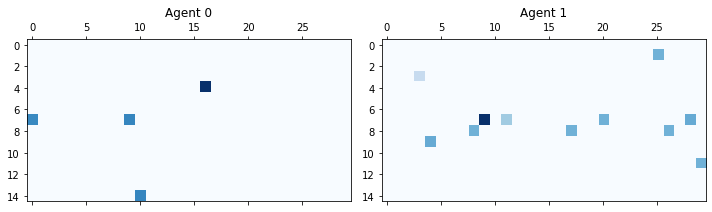

In [15]:
imgs = []
for checkpoint_dir in sorted(os.listdir(checkpoints_dir)):
    if os.path.isdir(os.path.join(checkpoints_dir, checkpoint_dir)):
        checkpoint_file = sorted(
            os.listdir(os.path.join(checkpoints_dir, checkpoint_dir))
        )[1]
        print(checkpoint_file)
        trainer.restore(os.path.join(checkpoints_dir, checkpoint_dir, checkpoint_file))
        agent_0 = trainer.get_policy("agent_0").model
        agent_1 = trainer.get_policy("agent_1").model
        with torch.no_grad():
            agent_0_matrix = agent_0._matrix.numpy()
            agent_1_matrix = agent_1._matrix.numpy()

            # Generate images
            for j, matrix in enumerate((agent_0_matrix, agent_1_matrix)):
                if j == 0:
                    fig = plt.figure(num=1, clear=True, figsize=(10, 10))
                    ax = fig.add_subplot(121)
                    ax.set_title("Agent 0")
                elif j == 1:
                    ax = fig.add_subplot(122)
                    ax.set_title("Agent 1")
                ax.matshow(matrix, cmap=plt.cm.Blues)
                for x in range(nb_msg):
                    for y in range(number_of_goals):
                        c = matrix[y, x]
                        #ax.text(x, y, str(round(c, 3)), va="center", ha="center")
                if j == 1:
                    plt.tight_layout()
                    canvas = fig.figure.canvas
                    canvas.draw()
                    data = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
                    img = data.reshape(canvas.get_width_height()[::-1] + (3,))
                    imgs.append(img)
                    

2022-10-24 17:05:40,366	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000010/checkpoint-10
2022-10-24 17:05:40,368	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': None, '_time_total': 581.4639339447021, '_episodes_total': 1200}


checkpoint-10


2022-10-24 17:05:40,892	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000020/checkpoint-20
2022-10-24 17:05:40,895	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': None, '_time_total': 1139.4355351924896, '_episodes_total': 2409}


checkpoint-20


2022-10-24 17:05:41,953	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000030/checkpoint-30
2022-10-24 17:05:41,956	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 30, '_timesteps_total': None, '_time_total': 1697.838029384613, '_episodes_total': 3622}


checkpoint-30


2022-10-24 17:05:42,546	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000040/checkpoint-40
2022-10-24 17:05:42,547	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 40, '_timesteps_total': None, '_time_total': 2251.175507068634, '_episodes_total': 4838}


checkpoint-40


2022-10-24 17:05:43,135	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000050/checkpoint-50
2022-10-24 17:05:43,137	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 50, '_timesteps_total': None, '_time_total': 2848.602220773697, '_episodes_total': 6057}


checkpoint-50


2022-10-24 17:05:43,724	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000060/checkpoint-60
2022-10-24 17:05:43,725	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 60, '_timesteps_total': None, '_time_total': 3406.588723897934, '_episodes_total': 7277}


checkpoint-60


2022-10-24 17:05:44,350	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000070/checkpoint-70
2022-10-24 17:05:44,352	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 70, '_timesteps_total': None, '_time_total': 3961.975340127945, '_episodes_total': 8494}


checkpoint-70


2022-10-24 17:05:44,945	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000080/checkpoint-80
2022-10-24 17:05:44,946	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 80, '_timesteps_total': None, '_time_total': 4516.012490987778, '_episodes_total': 9724}


checkpoint-80


2022-10-24 17:05:45,951	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000090/checkpoint-90
2022-10-24 17:05:45,952	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 90, '_timesteps_total': None, '_time_total': 5107.631624221802, '_episodes_total': 10939}


checkpoint-90


2022-10-24 17:05:46,518	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000100/checkpoint-100
2022-10-24 17:05:46,520	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 5647.112009048462, '_episodes_total': 12155}


checkpoint-100


2022-10-24 17:05:47,117	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000110/checkpoint-110
2022-10-24 17:05:47,118	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 110, '_timesteps_total': None, '_time_total': 6184.17902135849, '_episodes_total': 13371}


checkpoint-110


2022-10-24 17:05:47,745	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000120/checkpoint-120
2022-10-24 17:05:47,746	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 120, '_timesteps_total': None, '_time_total': 6729.678848743439, '_episodes_total': 14596}


checkpoint-120


2022-10-24 17:05:48,343	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000130/checkpoint-130
2022-10-24 17:05:48,344	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 130, '_timesteps_total': None, '_time_total': 7310.545959472656, '_episodes_total': 15819}


checkpoint-130


2022-10-24 17:05:48,946	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000140/checkpoint-140
2022-10-24 17:05:48,948	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 140, '_timesteps_total': None, '_time_total': 7845.742025136948, '_episodes_total': 17036}


checkpoint-140


2022-10-24 17:05:49,902	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000150/checkpoint-150
2022-10-24 17:05:49,904	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 150, '_timesteps_total': None, '_time_total': 8385.412364959717, '_episodes_total': 18263}


checkpoint-150


2022-10-24 17:05:50,518	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000160/checkpoint-160
2022-10-24 17:05:50,519	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 160, '_timesteps_total': None, '_time_total': 8926.947878360748, '_episodes_total': 19484}


checkpoint-160


2022-10-24 17:05:51,079	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000170/checkpoint-170
2022-10-24 17:05:51,084	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 170, '_timesteps_total': None, '_time_total': 9459.973507165909, '_episodes_total': 20707}


checkpoint-170


2022-10-24 17:05:51,674	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000180/checkpoint-180
2022-10-24 17:05:51,677	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 180, '_timesteps_total': None, '_time_total': 10039.521221876144, '_episodes_total': 21927}


checkpoint-180


2022-10-24 17:05:52,277	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000190/checkpoint-190
2022-10-24 17:05:52,279	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 190, '_timesteps_total': None, '_time_total': 10576.542331933975, '_episodes_total': 23163}


checkpoint-190


2022-10-24 17:05:52,872	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000200/checkpoint-200
2022-10-24 17:05:52,873	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 200, '_timesteps_total': None, '_time_total': 11115.74560713768, '_episodes_total': 24394}


checkpoint-200


2022-10-24 17:05:53,891	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000210/checkpoint-210
2022-10-24 17:05:53,892	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 210, '_timesteps_total': None, '_time_total': 11659.657379627228, '_episodes_total': 25630}


checkpoint-210


2022-10-24 17:05:54,539	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000220/checkpoint-220
2022-10-24 17:05:54,540	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 220, '_timesteps_total': None, '_time_total': 12190.370515108109, '_episodes_total': 26863}


checkpoint-220


2022-10-24 17:05:55,168	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000230/checkpoint-230
2022-10-24 17:05:55,170	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 230, '_timesteps_total': None, '_time_total': 12719.767742156982, '_episodes_total': 28095}


checkpoint-230


2022-10-24 17:05:55,777	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000240/checkpoint-240
2022-10-24 17:05:55,778	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 240, '_timesteps_total': None, '_time_total': 13246.49124789238, '_episodes_total': 29330}


checkpoint-240


2022-10-24 17:05:56,389	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000250/checkpoint-250
2022-10-24 17:05:56,391	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 250, '_timesteps_total': None, '_time_total': 13779.606154203415, '_episodes_total': 30560}


checkpoint-250


2022-10-24 17:05:56,955	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000260/checkpoint-260
2022-10-24 17:05:56,957	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 260, '_timesteps_total': None, '_time_total': 14311.878504276276, '_episodes_total': 31779}


checkpoint-260


2022-10-24 17:05:57,959	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000270/checkpoint-270
2022-10-24 17:05:57,960	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 270, '_timesteps_total': None, '_time_total': 14841.782404184341, '_episodes_total': 33003}


checkpoint-270


2022-10-24 17:05:58,608	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000280/checkpoint-280
2022-10-24 17:05:58,609	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 280, '_timesteps_total': None, '_time_total': 15373.934208393097, '_episodes_total': 34238}


checkpoint-280


2022-10-24 17:05:59,219	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000290/checkpoint-290
2022-10-24 17:05:59,222	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 290, '_timesteps_total': None, '_time_total': 15905.84736609459, '_episodes_total': 35460}


checkpoint-290


2022-10-24 17:05:59,834	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000300/checkpoint-300
2022-10-24 17:05:59,835	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 300, '_timesteps_total': None, '_time_total': 16434.486479759216, '_episodes_total': 36684}


checkpoint-300


2022-10-24 17:06:00,410	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000310/checkpoint-310
2022-10-24 17:06:00,412	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 310, '_timesteps_total': None, '_time_total': 16973.167477607727, '_episodes_total': 37906}


checkpoint-310


2022-10-24 17:06:00,974	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000320/checkpoint-320
2022-10-24 17:06:00,976	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 320, '_timesteps_total': None, '_time_total': 17509.17410159111, '_episodes_total': 39127}


checkpoint-320


2022-10-24 17:06:01,989	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000330/checkpoint-330
2022-10-24 17:06:01,991	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 330, '_timesteps_total': None, '_time_total': 18038.394006490707, '_episodes_total': 40343}


checkpoint-330


2022-10-24 17:06:02,617	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000340/checkpoint-340
2022-10-24 17:06:02,618	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 340, '_timesteps_total': None, '_time_total': 18576.646748542786, '_episodes_total': 41578}


checkpoint-340


2022-10-24 17:06:03,249	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000350/checkpoint-350
2022-10-24 17:06:03,250	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 350, '_timesteps_total': None, '_time_total': 19101.515020132065, '_episodes_total': 42806}


checkpoint-350


2022-10-24 17:06:03,892	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000360/checkpoint-360
2022-10-24 17:06:03,893	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 360, '_timesteps_total': None, '_time_total': 19633.903243780136, '_episodes_total': 44044}


checkpoint-360


2022-10-24 17:06:04,497	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000370/checkpoint-370
2022-10-24 17:06:04,499	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 370, '_timesteps_total': None, '_time_total': 20159.668039560318, '_episodes_total': 45281}


checkpoint-370


2022-10-24 17:06:05,133	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000380/checkpoint-380
2022-10-24 17:06:05,134	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 380, '_timesteps_total': None, '_time_total': 20682.10476255417, '_episodes_total': 46514}


checkpoint-380


2022-10-24 17:06:05,831	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000390/checkpoint-390
2022-10-24 17:06:05,833	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 390, '_timesteps_total': None, '_time_total': 21205.753875494003, '_episodes_total': 47749}


checkpoint-390


2022-10-24 17:06:06,421	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000400/checkpoint-400
2022-10-24 17:06:06,422	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 400, '_timesteps_total': None, '_time_total': 21740.786610126495, '_episodes_total': 48989}


checkpoint-400


2022-10-24 17:06:07,034	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000410/checkpoint-410
2022-10-24 17:06:07,036	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 410, '_timesteps_total': None, '_time_total': 22281.23215985298, '_episodes_total': 50222}


checkpoint-410


2022-10-24 17:06:07,674	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000420/checkpoint-420
2022-10-24 17:06:07,676	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 420, '_timesteps_total': None, '_time_total': 22817.145298719406, '_episodes_total': 51455}


checkpoint-420


2022-10-24 17:06:08,266	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000430/checkpoint-430
2022-10-24 17:06:08,270	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 430, '_timesteps_total': None, '_time_total': 23346.744125127792, '_episodes_total': 52696}


checkpoint-430


2022-10-24 17:06:08,888	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000440/checkpoint-440
2022-10-24 17:06:08,888	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 440, '_timesteps_total': None, '_time_total': 23875.50099015236, '_episodes_total': 53932}


checkpoint-440


2022-10-24 17:06:09,814	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000450/checkpoint-450
2022-10-24 17:06:09,815	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 450, '_timesteps_total': None, '_time_total': 24397.835186243057, '_episodes_total': 55165}


checkpoint-450


2022-10-24 17:06:10,387	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000460/checkpoint-460
2022-10-24 17:06:10,389	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 460, '_timesteps_total': None, '_time_total': 24933.40274810791, '_episodes_total': 56401}


checkpoint-460


2022-10-24 17:06:11,017	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000470/checkpoint-470
2022-10-24 17:06:11,019	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 470, '_timesteps_total': None, '_time_total': 25463.581179142, '_episodes_total': 57640}


checkpoint-470


2022-10-24 17:06:11,624	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000480/checkpoint-480
2022-10-24 17:06:11,625	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 480, '_timesteps_total': None, '_time_total': 25987.277344703674, '_episodes_total': 58858}


checkpoint-480


2022-10-24 17:06:12,234	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000490/checkpoint-490
2022-10-24 17:06:12,235	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 490, '_timesteps_total': None, '_time_total': 26508.43882417679, '_episodes_total': 60110}


checkpoint-490


2022-10-24 17:06:12,813	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000500/checkpoint-500
2022-10-24 17:06:12,815	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 500, '_timesteps_total': None, '_time_total': 27033.152046442032, '_episodes_total': 61343}


checkpoint-500


2022-10-24 17:06:13,862	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000510/checkpoint-510
2022-10-24 17:06:13,863	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 510, '_timesteps_total': None, '_time_total': 27547.870509386063, '_episodes_total': 62573}


checkpoint-510


2022-10-24 17:06:14,511	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000520/checkpoint-520
2022-10-24 17:06:14,513	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 520, '_timesteps_total': None, '_time_total': 28091.57023882866, '_episodes_total': 63828}


checkpoint-520


2022-10-24 17:06:15,151	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000530/checkpoint-530
2022-10-24 17:06:15,152	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 530, '_timesteps_total': None, '_time_total': 28603.911620140076, '_episodes_total': 65057}


checkpoint-530


2022-10-24 17:06:15,747	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000540/checkpoint-540
2022-10-24 17:06:15,749	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 540, '_timesteps_total': None, '_time_total': 29132.66295671463, '_episodes_total': 66298}


checkpoint-540


2022-10-24 17:06:16,396	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000550/checkpoint-550
2022-10-24 17:06:16,397	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 550, '_timesteps_total': None, '_time_total': 29654.81418299675, '_episodes_total': 67525}


checkpoint-550


2022-10-24 17:06:17,006	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000560/checkpoint-560
2022-10-24 17:06:17,007	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 560, '_timesteps_total': None, '_time_total': 30172.565808534622, '_episodes_total': 68747}


checkpoint-560


2022-10-24 17:06:18,008	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000570/checkpoint-570
2022-10-24 17:06:18,010	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 570, '_timesteps_total': None, '_time_total': 30737.04300045967, '_episodes_total': 69987}


checkpoint-570


2022-10-24 17:06:18,620	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000580/checkpoint-580
2022-10-24 17:06:18,621	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 580, '_timesteps_total': None, '_time_total': 31259.65331673622, '_episodes_total': 71234}


checkpoint-580


2022-10-24 17:06:19,253	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000590/checkpoint-590
2022-10-24 17:06:19,255	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 590, '_timesteps_total': None, '_time_total': 31791.073875665665, '_episodes_total': 72487}


checkpoint-590


2022-10-24 17:06:19,878	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000600/checkpoint-600
2022-10-24 17:06:19,879	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 600, '_timesteps_total': None, '_time_total': 32326.51610684395, '_episodes_total': 73740}


checkpoint-600


2022-10-24 17:06:20,480	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000610/checkpoint-610
2022-10-24 17:06:20,481	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 610, '_timesteps_total': None, '_time_total': 32844.945220947266, '_episodes_total': 74983}


checkpoint-610


2022-10-24 17:06:21,047	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000620/checkpoint-620
2022-10-24 17:06:21,050	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 620, '_timesteps_total': None, '_time_total': 33360.24616217613, '_episodes_total': 76246}


checkpoint-620


2022-10-24 17:06:21,989	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000630/checkpoint-630
2022-10-24 17:06:21,990	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 630, '_timesteps_total': None, '_time_total': 33868.55232453346, '_episodes_total': 77482}


checkpoint-630


2022-10-24 17:06:22,533	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000640/checkpoint-640
2022-10-24 17:06:22,537	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 640, '_timesteps_total': None, '_time_total': 34380.77482128143, '_episodes_total': 78715}


checkpoint-640


2022-10-24 17:06:23,134	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000650/checkpoint-650
2022-10-24 17:06:23,135	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 650, '_timesteps_total': None, '_time_total': 34892.57383322716, '_episodes_total': 79960}


checkpoint-650


2022-10-24 17:06:23,767	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000660/checkpoint-660
2022-10-24 17:06:23,768	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 660, '_timesteps_total': None, '_time_total': 35403.42414164543, '_episodes_total': 81201}


checkpoint-660


2022-10-24 17:06:24,381	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000670/checkpoint-670
2022-10-24 17:06:24,382	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 670, '_timesteps_total': None, '_time_total': 35929.88591146469, '_episodes_total': 82457}


checkpoint-670


2022-10-24 17:06:24,930	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000680/checkpoint-680
2022-10-24 17:06:24,932	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 680, '_timesteps_total': None, '_time_total': 36433.87432169914, '_episodes_total': 83703}


checkpoint-680


2022-10-24 17:06:25,815	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000690/checkpoint-690
2022-10-24 17:06:25,816	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 690, '_timesteps_total': None, '_time_total': 36942.34767866135, '_episodes_total': 84946}


checkpoint-690


2022-10-24 17:06:26,434	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000700/checkpoint-700
2022-10-24 17:06:26,435	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 700, '_timesteps_total': None, '_time_total': 37455.97346615791, '_episodes_total': 86203}


checkpoint-700


2022-10-24 17:06:27,033	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000710/checkpoint-710
2022-10-24 17:06:27,036	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 710, '_timesteps_total': None, '_time_total': 37957.30130624771, '_episodes_total': 87447}


checkpoint-710


2022-10-24 17:06:27,650	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000720/checkpoint-720
2022-10-24 17:06:27,651	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 720, '_timesteps_total': None, '_time_total': 38469.88358139992, '_episodes_total': 88683}


checkpoint-720


2022-10-24 17:06:28,184	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000730/checkpoint-730
2022-10-24 17:06:28,185	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 730, '_timesteps_total': None, '_time_total': 38975.43799138069, '_episodes_total': 89924}


checkpoint-730


2022-10-24 17:06:28,784	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000740/checkpoint-740
2022-10-24 17:06:28,785	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 740, '_timesteps_total': None, '_time_total': 39485.52091240883, '_episodes_total': 91187}


checkpoint-740


2022-10-24 17:06:29,733	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000750/checkpoint-750
2022-10-24 17:06:29,735	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 750, '_timesteps_total': None, '_time_total': 39999.24658489227, '_episodes_total': 92429}


checkpoint-750


2022-10-24 17:06:30,344	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000760/checkpoint-760
2022-10-24 17:06:30,345	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 760, '_timesteps_total': None, '_time_total': 40508.12497186661, '_episodes_total': 93712}


checkpoint-760


2022-10-24 17:06:30,920	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000770/checkpoint-770
2022-10-24 17:06:30,922	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 770, '_timesteps_total': None, '_time_total': 41014.24797320366, '_episodes_total': 94956}


checkpoint-770


2022-10-24 17:06:31,471	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000780/checkpoint-780
2022-10-24 17:06:31,472	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 780, '_timesteps_total': None, '_time_total': 41517.6982524395, '_episodes_total': 96224}


checkpoint-780


2022-10-24 17:06:32,066	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000790/checkpoint-790
2022-10-24 17:06:32,067	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 790, '_timesteps_total': None, '_time_total': 42027.9639005661, '_episodes_total': 97507}


checkpoint-790


2022-10-24 17:06:32,645	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000800/checkpoint-800
2022-10-24 17:06:32,646	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 800, '_timesteps_total': None, '_time_total': 42527.68366909027, '_episodes_total': 98748}


checkpoint-800


2022-10-24 17:06:33,591	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000810/checkpoint-810
2022-10-24 17:06:33,592	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 810, '_timesteps_total': None, '_time_total': 43030.413056612015, '_episodes_total': 99991}


checkpoint-810


2022-10-24 17:06:34,145	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000820/checkpoint-820
2022-10-24 17:06:34,147	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 820, '_timesteps_total': None, '_time_total': 43533.04277777672, '_episodes_total': 101230}


checkpoint-820


2022-10-24 17:06:34,731	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000830/checkpoint-830
2022-10-24 17:06:34,733	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 830, '_timesteps_total': None, '_time_total': 44042.17241382599, '_episodes_total': 102471}


checkpoint-830


2022-10-24 17:06:35,314	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000840/checkpoint-840
2022-10-24 17:06:35,315	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 840, '_timesteps_total': None, '_time_total': 44540.50792455673, '_episodes_total': 103720}


checkpoint-840


2022-10-24 17:06:35,906	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000850/checkpoint-850
2022-10-24 17:06:35,907	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 850, '_timesteps_total': None, '_time_total': 45044.68501496315, '_episodes_total': 104971}


checkpoint-850


2022-10-24 17:06:36,516	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000860/checkpoint-860
2022-10-24 17:06:36,517	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 860, '_timesteps_total': None, '_time_total': 45542.81378173828, '_episodes_total': 106218}


checkpoint-860


2022-10-24 17:06:37,364	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000870/checkpoint-870
2022-10-24 17:06:37,366	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 870, '_timesteps_total': None, '_time_total': 46035.45520687103, '_episodes_total': 107482}


checkpoint-870


2022-10-24 17:06:37,971	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000880/checkpoint-880
2022-10-24 17:06:37,972	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 880, '_timesteps_total': None, '_time_total': 46542.29817152023, '_episodes_total': 108733}


checkpoint-880


2022-10-24 17:06:38,568	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000890/checkpoint-890
2022-10-24 17:06:38,569	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 890, '_timesteps_total': None, '_time_total': 47040.062027692795, '_episodes_total': 109963}


checkpoint-890


2022-10-24 17:06:39,158	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000900/checkpoint-900
2022-10-24 17:06:39,160	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 900, '_timesteps_total': None, '_time_total': 47535.37647271156, '_episodes_total': 111214}


checkpoint-900


2022-10-24 17:06:39,723	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000910/checkpoint-910
2022-10-24 17:06:39,725	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 910, '_timesteps_total': None, '_time_total': 48040.194423913956, '_episodes_total': 112465}


checkpoint-910


2022-10-24 17:06:40,670	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000920/checkpoint-920
2022-10-24 17:06:40,673	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 920, '_timesteps_total': None, '_time_total': 48542.43450093269, '_episodes_total': 113702}


checkpoint-920


2022-10-24 17:06:41,280	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000930/checkpoint-930
2022-10-24 17:06:41,281	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 930, '_timesteps_total': None, '_time_total': 49050.93221116066, '_episodes_total': 114955}


checkpoint-930


2022-10-24 17:06:41,856	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000940/checkpoint-940
2022-10-24 17:06:41,857	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 940, '_timesteps_total': None, '_time_total': 49548.91114735603, '_episodes_total': 116186}


checkpoint-940


2022-10-24 17:06:42,391	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000950/checkpoint-950
2022-10-24 17:06:42,392	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 950, '_timesteps_total': None, '_time_total': 50040.35582900047, '_episodes_total': 117442}


checkpoint-950


2022-10-24 17:06:42,805	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000960/checkpoint-960
2022-10-24 17:06:42,806	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 960, '_timesteps_total': None, '_time_total': 50540.39477753639, '_episodes_total': 118695}


checkpoint-960


2022-10-24 17:06:43,372	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000970/checkpoint-970
2022-10-24 17:06:43,374	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 970, '_timesteps_total': None, '_time_total': 51041.172718286514, '_episodes_total': 119942}


checkpoint-970


2022-10-24 17:06:44,350	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000980/checkpoint-980
2022-10-24 17:06:44,350	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 980, '_timesteps_total': None, '_time_total': 51543.41252565384, '_episodes_total': 121205}


checkpoint-980


2022-10-24 17:06:44,972	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_000990/checkpoint-990
2022-10-24 17:06:44,974	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 990, '_timesteps_total': None, '_time_total': 52048.25040221214, '_episodes_total': 122455}


checkpoint-990


2022-10-24 17:06:45,569	INFO trainable.py:588 -- Restored on 10.159.0.14 from checkpoint: /gpfsscratch/rech/imi/uzw47io/elias_expe/4_agents/cooperative/modified_reward/6_landmarks/naming_game_30msg/2022-10-23_13-36-480wh6sbwt/checkpoint_001000/checkpoint-1000
2022-10-24 17:06:45,571	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 1000, '_timesteps_total': None, '_time_total': 52536.96619606018, '_episodes_total': 123737}


checkpoint-1000


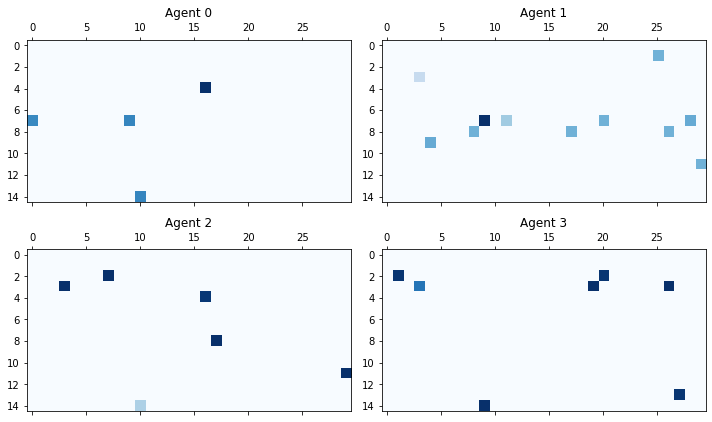

In [18]:
imgs = []
for checkpoint_dir in sorted(os.listdir(checkpoints_dir)):
    if os.path.isdir(os.path.join(checkpoints_dir, checkpoint_dir)):
        checkpoint_file = sorted(
            os.listdir(os.path.join(checkpoints_dir, checkpoint_dir))
        )[1]
        print(checkpoint_file)
        trainer.restore(os.path.join(checkpoints_dir, checkpoint_dir, checkpoint_file))
        agent_0 = trainer.get_policy("agent_0").model
        agent_1 = trainer.get_policy("agent_1").model
        agent_2 = trainer.get_policy("agent_2").model
        agent_3 = trainer.get_policy("agent_3").model
        with torch.no_grad():
            agent_0_matrix = agent_0._matrix.numpy()
            agent_1_matrix = agent_1._matrix.numpy()
            agent_2_matrix = agent_2._matrix.numpy()
            agent_3_matrix = agent_3._matrix.numpy()

            # Generate images
            for j, matrix in enumerate((agent_0_matrix, agent_1_matrix,agent_2_matrix,agent_3_matrix)):
                if j == 0:
                    fig = plt.figure(num=1, clear=True, figsize=(10, 10))
                    ax = fig.add_subplot(221)
                    ax.set_title("Agent 0")
                elif j == 1:
                    ax = fig.add_subplot(222)
                    ax.set_title("Agent 1")
                elif j==2:
                    ax = fig.add_subplot(223)
                    ax.set_title("Agent 2")
                elif j==3:
                    ax = fig.add_subplot(224)
                    ax.set_title("Agent 3")
                    
                ax.matshow(matrix, cmap=plt.cm.Blues)
                for x in range(nb_msg):
                    for y in range(number_of_goals):
                        c = matrix[y, x]
                        #ax.text(x, y, str(round(c, 3)), va="center", ha="center")
                if j == 3:
                    plt.tight_layout()
                    canvas = fig.figure.canvas
                    canvas.draw()
                    data = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
                    img = data.reshape(canvas.get_width_height()[::-1] + (3,))
                    imgs.append(img)
                    

In [19]:
import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
from IPython.display import HTML, display, clear_output

class VideoWriter:
  def __init__(self, filename, fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))

In [22]:
with VideoWriter("out.mp4", 2) as vid:
          for i in range(len(imgs)):
            im = imgs[i]
            
            #plt.imshow(im)
            #plt.show()
            vid.add(im)
          vid.show()

# 2 matrix

In [13]:
with open(f"../scripts/configs/{config_file}", "r") as f:
    user_config = yaml.safe_load(f)
# General settings of the algorithm
config = deepcopy(DEFAULT_CONFIG)
config["num_workers"] = 0
config["framework"] = "torch"
use_communication = user_config.get("communication", False)

config["horizon"] = population.LARGE_GOAL_LINES_TIMELIMIT
config["rollout_fragment_length"] = config["horizon"]
config["env_config"] = user_config["env_config"]
config["train_batch_size"] = 60_000
config["sgd_minibatch_size"] = 10_000
config["lambda"] = 0.9
config["lr"] = 0.0003


def policy_mapping_fn(agent_id):
    return agent_id


config["multiagent"] = {
    "policies": {
        f"agent_{i}": PolicySpec(
            policy_class=None, observation_space=None, action_space=None
        )
        for i in range(config["env_config"]["population_size"])
    },
    "policy_mapping_fn": policy_mapping_fn,
}

train_env = environment

ModelCatalog.register_custom_model("FullNamingNetwork", FullNamingNetwork)
number_of_goals = environment(config["env_config"]).goal_space_dim
config["model"] = {
    "custom_model": "FullNamingNetwork",
    "custom_model_config": {
        "number_of_goals": number_of_goals,
        "train_matrix": user_config.get("train_matrix", False),
    },
}
trainer = FullNamingTrainer(
    config=config,
    env=train_env,
)

2022-10-17 14:55:47,202	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-10-17 14:55:47,203	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-10-17 14:55:47,203	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-10-17 14:55:47,203	WARNING multi_agent_env.py:193 -- action_space_sample() has not been implemented
2022-10-17 14:55:47,205	WARNING multi_agent_env.py:137 -- observation_space_contains() has not been implemented
2022-10-17 14:55:47,211	WARNING catalog.py:628 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2022-10-17 14:55:47,240	WARNING catalog.py:628 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2022-10-17 14:55:47,248	WARNING util.py:65 -- Install gputil for GPU system monitoring.


In [ ]:
imgs = []
for checkpoint_dir in sorted(os.listdir(checkpoints_dir)):
    if os.path.isdir(os.path.join(checkpoints_dir, checkpoint_dir)):
        checkpoint_file = sorted(
            os.listdir(os.path.join(checkpoints_dir, checkpoint_dir))
        )[1]
        trainer.restore(os.path.join(checkpoints_dir, checkpoint_dir, checkpoint_file))
        agent_0 = trainer.get_policy("agent_0").model
        agent_1 = trainer.get_policy("agent_1").model
        with torch.no_grad():
            agent_0_matrix = agent_0._leader_matrix.numpy()
            agent_1_matrix = agent_1._follower_matrix.numpy()

            # Generate images
            for j, matrix in enumerate((agent_0_matrix, agent_1_matrix)):
                if j == 0:
                    fig = plt.figure(num=1, clear=True, figsize=(10, 10))
                    ax = fig.add_subplot(121)
                    ax.set_title("Agent 0")
                elif j == 1:
                    ax = fig.add_subplot(122)
                    ax.set_title("Agent 1")
                ax.matshow(matrix, cmap=plt.cm.Blues)
                for x in range(number_of_goals):
                    for y in range(number_of_goals):
                        c = matrix[y, x]
                        ax.text(x, y, str(round(c, 3)), va="center", ha="center")
                if j == 1:
                    plt.tight_layout()
                    canvas = fig.figure.canvas
                    canvas.draw()
                    data = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
                    img = data.reshape(canvas.get_width_height()[::-1] + (3,))
                    imgs.append(img)
                    